Training accuracy: 0.97


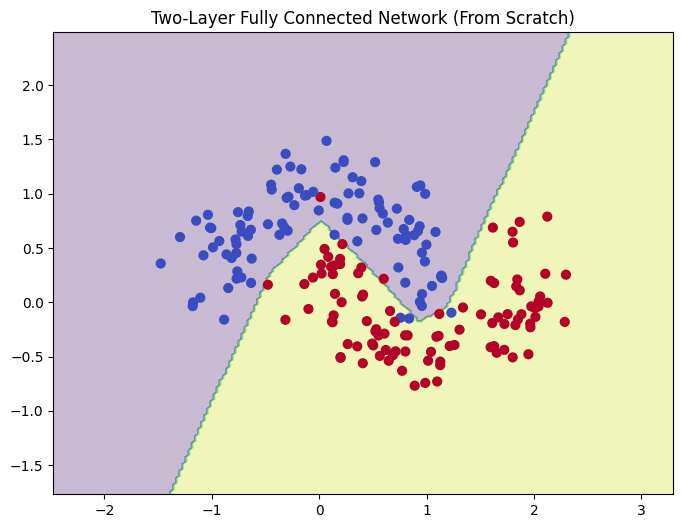

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# 1️⃣ Create non-linear synthetic dataset
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

# 2️⃣ Initialize parameters
def initialize_parameters(input_dim, hidden_dim, output_dim):
    np.random.seed(42)
    W1 = np.random.randn(input_dim, hidden_dim) * 0.1
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) * 0.1
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

# 3️⃣ Activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

# 4️⃣ Loss function
def compute_loss(y, A2):
    m = len(y)
    return -np.mean(y*np.log(A2 + 1e-9) + (1-y)*np.log(1-A2 + 1e-9))

# 5️⃣ Training
def train(X, y, hidden_dim=10, lr=0.1, epochs=5000):
    m, input_dim = X.shape
    output_dim = 1

    W1, b1, W2, b2 = initialize_parameters(input_dim, hidden_dim, output_dim)
    losses = []

    for _ in range(epochs):

        # Forward pass
        Z1 = X @ W1 + b1
        A1 = relu(Z1)
        Z2 = A1 @ W2 + b2
        A2 = sigmoid(Z2)

        # Loss
        loss = compute_loss(y, A2)
        losses.append(loss)

        # Backpropagation
        dZ2 = A2 - y
        dW2 = (A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ W2.T
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

    return W1, b1, W2, b2, losses

# Train model
W1, b1, W2, b2, losses = train(X, y, hidden_dim=16, lr=0.1, epochs=5000)

# 6️⃣ Prediction function
def predict(X, W1, b1, W2, b2):
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = sigmoid(Z2)
    return (A2 > 0.5).astype(int)

y_pred = predict(X, W1, b1, W2, b2)
print("Training accuracy:", np.mean(y_pred == y))


plt.figure(figsize=(8,6))

# Create grid
x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid, W1, b1, W2, b2)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='coolwarm', s=40)

plt.title("Two-Layer Fully Connected Network (From Scratch)")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# 1️⃣ Create dataset
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

# 2️⃣ Define Model
class TwoLayerNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)   # No sigmoid here!
        return x

# 3️⃣ Initialize model
model = TwoLayerNet(input_dim=2, hidden_dim=16, output_dim=1)

# 4️⃣ Loss + Optimizer (implicit gradient handling)
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# optimizer = optim.SGD(model.parameters(), lr=0.1)

# 5️⃣ Training loop
epochs = 5000
losses = []

for epoch in range(epochs):

    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    losses.append(loss.item())

    # Backward pass (autograd)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 6️⃣ Prediction
with torch.no_grad():
    logits = model(X)
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.5).float()

accuracy = (y_pred == y).float().mean()
print("Training accuracy:", accuracy.item())


Training accuracy: 0.9700000286102295


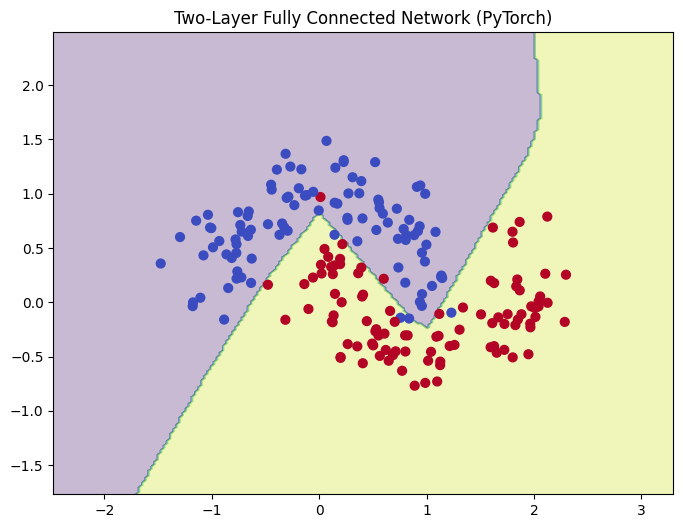

In [ ]:
plt.figure(figsize=(8,6))

# Create grid
x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1

xx, yy = np.meshgrid(
    np.linspace(x_min.item(), x_max.item(), 200),
    np.linspace(y_min.item(), y_max.item(), 200)
)

grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    logits = model(grid)
    probs = torch.sigmoid(logits)
    Z = (probs > 0.5).float().numpy()

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y.numpy().flatten(), cmap='coolwarm', s=40)

plt.title("Two-Layer Fully Connected Network (PyTorch)")
plt.show()


SGD | Epoch 0 | Loss: 0.7424
SGD | Epoch 100 | Loss: 0.6509
SGD | Epoch 200 | Loss: 0.5888
SGD | Epoch 300 | Loss: 0.5377
SGD | Epoch 400 | Loss: 0.4949
SGD | Epoch 500 | Loss: 0.4599
SGD | Epoch 600 | Loss: 0.4322
SGD | Epoch 700 | Loss: 0.4107
SGD | Epoch 800 | Loss: 0.3939
SGD | Epoch 900 | Loss: 0.3804
SGD | Epoch 1000 | Loss: 0.3694
SGD | Epoch 1100 | Loss: 0.3602
SGD | Epoch 1200 | Loss: 0.3523
SGD | Epoch 1300 | Loss: 0.3454
SGD | Epoch 1400 | Loss: 0.3393
SGD | Epoch 1500 | Loss: 0.3339
SGD | Epoch 1600 | Loss: 0.3290
SGD | Epoch 1700 | Loss: 0.3246
SGD | Epoch 1800 | Loss: 0.3208
SGD | Epoch 1900 | Loss: 0.3173
SGD | Epoch 2000 | Loss: 0.3141
SGD | Epoch 2100 | Loss: 0.3112
SGD | Epoch 2200 | Loss: 0.3086
SGD | Epoch 2300 | Loss: 0.3062
SGD | Epoch 2400 | Loss: 0.3040
SGD | Epoch 2500 | Loss: 0.3019
SGD | Epoch 2600 | Loss: 0.2998
SGD | Epoch 2700 | Loss: 0.2979
SGD | Epoch 2800 | Loss: 0.2961
SGD | Epoch 2900 | Loss: 0.2944
SGD | Epoch 3000 | Loss: 0.2928
SGD | Epoch 3100 | L

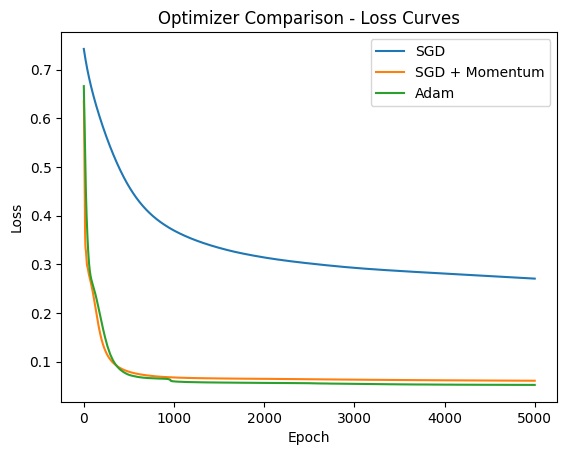

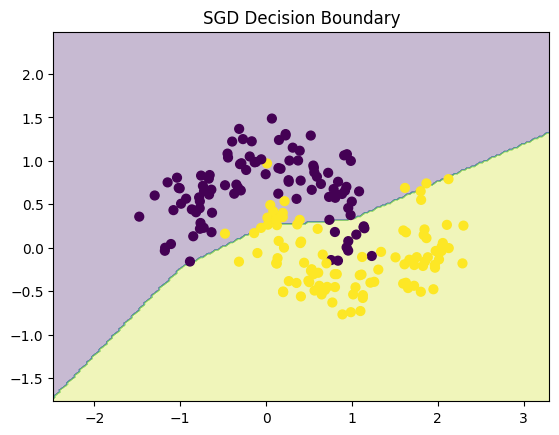

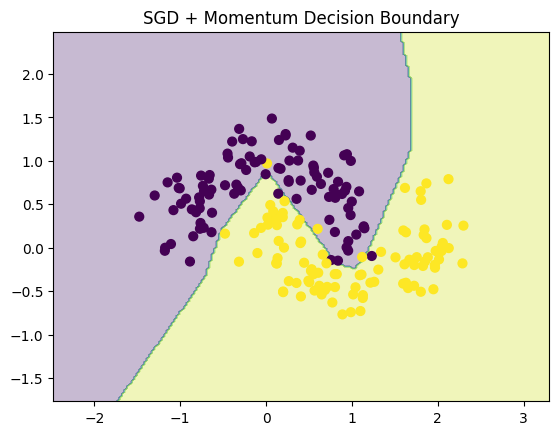

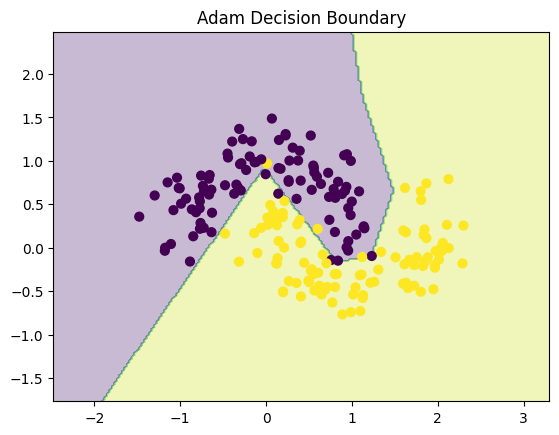

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# =====================
# Dataset
# =====================
X_np, y_np = make_moons(n_samples=200, noise=0.2, random_state=42)

X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np.reshape(-1, 1), dtype=torch.float32)

# =====================
# Model
# =====================
class TwoLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# =====================
# Training Function
# =====================
def train(optimizer_name, lr, epochs=5000):
    model = TwoLayerNet()
    criterion = nn.BCEWithLogitsLoss()

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Unknown optimizer")

    losses = []

    for epoch in range(epochs):
        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"{optimizer_name} | Epoch {epoch} | Loss: {loss.item():.4f}")

    return model, losses

# =====================
# Train Models
# =====================
sgd_model, sgd_losses = train("SGD", lr=0.01)
momentum_model, momentum_losses = train("Momentum", lr=0.1)
adam_model, adam_losses = train("Adam", lr=0.01)

# =====================
# Prediction Function
# =====================
def predict(model, X):
    with torch.no_grad():
        logits = model(X)
        probs = torch.sigmoid(logits)
        return (probs > 0.5).float()

# Compute Accuracy
for name, model in [("SGD", sgd_model),
                    ("Momentum", momentum_model),
                    ("Adam", adam_model)]:

    y_pred = predict(model, X)
    acc = (y_pred == y).float().mean()
    print(f"{name} Accuracy: {acc.item():.4f}")

# =====================
# Plot Loss Curves
# =====================
plt.figure()
plt.plot(sgd_losses, label="SGD")
plt.plot(momentum_losses, label="SGD + Momentum")
plt.plot(adam_losses, label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Optimizer Comparison - Loss Curves")
plt.legend()
plt.show()

# =====================
# Decision Boundary Visualization
# =====================
def plot_decision_boundary(model, title):
    x_min, x_max = X_np[:, 0].min()-1, X_np[:, 0].max()+1
    y_min, y_max = X_np[:, 1].min()-1, X_np[:, 1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()],
                        dtype=torch.float32)

    with torch.no_grad():
        logits = model(grid)
        probs = torch.sigmoid(logits)
        Z = (probs > 0.5).float().numpy()

    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=40)
    plt.title(title)
    plt.show()

plot_decision_boundary(sgd_model, "SGD Decision Boundary")
plot_decision_boundary(momentum_model, "SGD + Momentum Decision Boundary")
plot_decision_boundary(adam_model, "Adam Decision Boundary")
